In [1]:
import torch 
from torch.nn import functional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [30]:
#datset
data=pd.read_csv("dataset/Iris.csv")
data = data[data["Species"].isin(['Iris-setosa', 'Iris-versicolor'])]
data['Species'] = data['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1})
X = data[['SepalLengthCm', 'SepalWidthCm']].values.tolist()
y = list(data['Species'])
print("len of X: ",len(X))
print("len of y: ",len(y))
print(X[:5])
print(y[:5])
X=torch.tensor(X,dtype=torch.float32)
y=torch.tensor(y,dtype=torch.float32)
torch.manual_seed(42)
shuffle_indices= torch.randperm(len(y),dtype=torch.long)
X=X[shuffle_indices]
y=y[shuffle_indices]
x_train,x_test=X[:70],X[70:]
y_train,y_test=y[:70],y[70:]
# Standarization
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
X_train = (x_train - mu) / sigma
X_test = (x_test - mu) / sigma

len of X:  100
len of y:  100
[[5.1, 3.5], [4.9, 3.0], [4.7, 3.2], [4.6, 3.1], [5.0, 3.6]]
[0, 0, 0, 0, 0]


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
#L2 regularization manual
class Logistic_regression(torch.nn.Module):
    def __init__(self, num_features=2):
        super(Logistic_regression, self).__init__()
        self.layer=torch.nn.Linear(num_features,1)
        self.layer.weight.detach().zero_()
        self.layer.bias.detach().zero_()
    
    def forward(self, x):
        logits=self.layer(x)
        probs=functional.sigmoid(logits)
        return probs

def accuracy(y, pred_prob):
    pred_prob=pred_prob.view(-1).float()
    y_pred=torch.where(pred_prob >= 0.5, 1, 0)
    acc=sum(p == t for p, t in zip(y_pred, y))/len(y)
    return acc

def train(X,y,model, epochs=10, lr=0.01):
    loss_per_epoch=[]
    LAMBDA=2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 

    for e in range(epochs):
        y_pred=model(X)
        loss=functional.binary_cross_entropy(y_pred, y, reduction='sum')
        loss = loss + 0.5 * LAMBDA * torch.mm(model.layer.weight,model.layer.weight.t())
        loss = loss + 0.5 * LAMBDA * model.layer.bias**2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred=model(X)
        acc=accuracy(y,y_pred).item()
        loss=functional.binary_cross_entropy(y_pred, y)
        print(f"Epoch : {e}  ; Current loss: {loss}; Accuracy: {acc}")
        ls=loss.item()
        loss_per_epoch.append(ls)
    return loss_per_epoch



In [15]:
model1=Logistic_regression().to(device)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
loss=train(X_train,y_train,model1, epochs=100)

C:\Users\HP\AppData\Local\Temp\ipykernel_9208\1240916426.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
C:\Users\HP\AppData\Local\Temp\ipykernel_9208\1240916426.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


Epoch : 0  ; Current loss: 0.5318381786346436; Accuracy: 1.0
Epoch : 1  ; Current loss: 0.4319305419921875; Accuracy: 1.0
Epoch : 2  ; Current loss: 0.3664754033088684; Accuracy: 1.0
Epoch : 3  ; Current loss: 0.3209812641143799; Accuracy: 1.0
Epoch : 4  ; Current loss: 0.2877541184425354; Accuracy: 1.0
Epoch : 5  ; Current loss: 0.2625108063220978; Accuracy: 1.0
Epoch : 6  ; Current loss: 0.2427254021167755; Accuracy: 1.0
Epoch : 7  ; Current loss: 0.2268262654542923; Accuracy: 1.0
Epoch : 8  ; Current loss: 0.213789165019989; Accuracy: 1.0
Epoch : 9  ; Current loss: 0.20291969180107117; Accuracy: 1.0
Epoch : 10  ; Current loss: 0.19373095035552979; Accuracy: 1.0
Epoch : 11  ; Current loss: 0.18587185442447662; Accuracy: 1.0
Epoch : 12  ; Current loss: 0.1790827065706253; Accuracy: 1.0
Epoch : 13  ; Current loss: 0.1731674075126648; Accuracy: 1.0
Epoch : 14  ; Current loss: 0.1679750382900238; Accuracy: 1.0
Epoch : 15  ; Current loss: 0.16338762640953064; Accuracy: 1.0
Epoch : 16  ; C

In [23]:
print("weight: ",model1.layer.weight)
print("bias: ",model1.layer.bias)

weight:  Parameter containing:
tensor([[ 1.8123, -1.7235]], device='cuda:0', requires_grad=True)
bias:  Parameter containing:
tensor([0.2421], device='cuda:0', requires_grad=True)


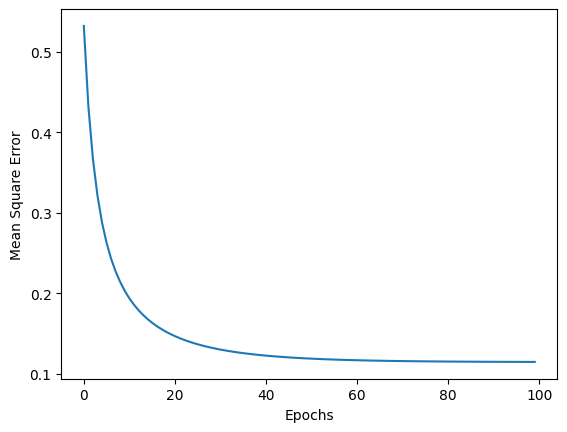

In [12]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()

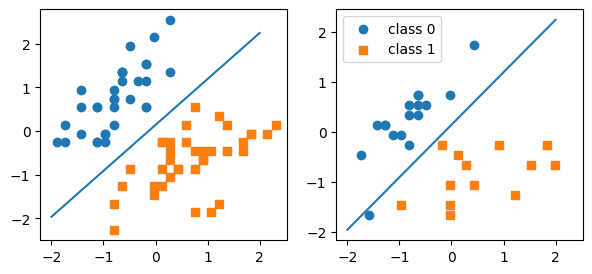

In [22]:
w, b = model1.layer.weight.detach().view(-1), model1.layer.bias.detach()
x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] ).item()

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] ).item()


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])
x_train_plt=X_train.to('cpu')
x_test_plt=X_test.to('cpu')
y_test_plt=y_test.to('cpu')
y_train_plt=y_train.to('cpu')
ax[0].scatter(x_train_plt[y_train_plt==0, 0], x_train_plt[y_train_plt==0, 1], label='class 0', marker='o')
ax[0].scatter(x_train_plt[y_train_plt==1, 0], x_train_plt[y_train_plt==1, 1], label='class 1', marker='s')

ax[1].scatter(x_test_plt[y_test_plt==0, 0], x_test_plt[y_test_plt==0, 1], label='class 0', marker='o')
ax[1].scatter(x_test_plt[y_test_plt==1, 0], x_test_plt[y_test_plt==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [34]:
test_results=model1(X_test.to(device))
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Correct : ",correct.tolist())
print("Wrong: ",len(y_test)-correct.item())
print("Accuracy: ", correct.item()/len(y_test) )


Correct :  29
Wrong:  1
Accuracy:  0.9666666666666667


In [27]:
#L2 regularization by weight decay in optimizer
class Logistic_regression2(torch.nn.Module):
    def __init__(self, num_features=2):
        super(Logistic_regression2, self).__init__()
        self.layer=torch.nn.Linear(num_features,1)
        self.layer.weight.detach().zero_()
        self.layer.bias.detach().zero_()
    
    def forward(self, x):
        logits=self.layer(x)
        probs=functional.sigmoid(logits)
        return probs

def accuracy(y, pred_prob):
    pred_prob=pred_prob.view(-1).float()
    y_pred=torch.where(pred_prob >= 0.5, 1, 0)
    acc=sum(p == t for p, t in zip(y_pred, y))/len(y)
    return acc

def train(X,y,model, epochs=10, lr=0.01):
    loss_per_epoch=[]
    LAMBDA=2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=LAMBDA) 

    for e in range(epochs):
        y_pred=model(X)
        loss=functional.binary_cross_entropy(y_pred, y, reduction='sum')
        loss = loss + 0.5 * LAMBDA * torch.mm(model.layer.weight,model.layer.weight.t())
        loss = loss + 0.5 * LAMBDA * model.layer.bias**2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred=model(X)
        acc=accuracy(y,y_pred).item()
        loss=functional.binary_cross_entropy(y_pred, y)
        print(f"Epoch : {e}  ; Current loss: {loss}; Accuracy: {acc}")
        ls=loss.item()
        loss_per_epoch.append(ls)
    return loss_per_epoch



In [28]:
model2=Logistic_regression2().to(device)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
loss=train(X_train,y_train,model2, epochs=100)

C:\Users\HP\AppData\Local\Temp\ipykernel_9208\33056932.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
C:\Users\HP\AppData\Local\Temp\ipykernel_9208\33056932.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


Epoch : 0  ; Current loss: 0.5318381786346436; Accuracy: 1.0
Epoch : 1  ; Current loss: 0.4342666268348694; Accuracy: 1.0
Epoch : 2  ; Current loss: 0.371529221534729; Accuracy: 1.0
Epoch : 3  ; Current loss: 0.3286295235157013; Accuracy: 1.0
Epoch : 4  ; Current loss: 0.2977800965309143; Accuracy: 1.0
Epoch : 5  ; Current loss: 0.274706095457077; Accuracy: 1.0
Epoch : 6  ; Current loss: 0.25690993666648865; Accuracy: 1.0
Epoch : 7  ; Current loss: 0.24284793436527252; Accuracy: 1.0
Epoch : 8  ; Current loss: 0.23151926696300507; Accuracy: 1.0
Epoch : 9  ; Current loss: 0.22224801778793335; Accuracy: 1.0
Epoch : 10  ; Current loss: 0.21456195414066315; Accuracy: 1.0
Epoch : 11  ; Current loss: 0.2081213742494583; Accuracy: 1.0
Epoch : 12  ; Current loss: 0.20267565548419952; Accuracy: 1.0
Epoch : 13  ; Current loss: 0.1980360895395279; Accuracy: 1.0
Epoch : 14  ; Current loss: 0.19405756890773773; Accuracy: 1.0
Epoch : 15  ; Current loss: 0.19062699377536774; Accuracy: 1.0
Epoch : 16  

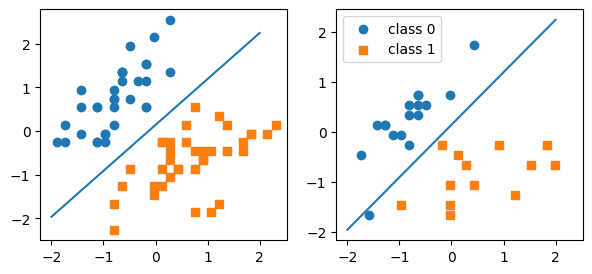

In [31]:
w, b = model1.layer.weight.detach().view(-1), model1.layer.bias.detach()
x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] ).item()

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] ).item()


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])
x_train_plt=X_train.to('cpu')
x_test_plt=X_test.to('cpu')
y_test_plt=y_test.to('cpu')
y_train_plt=y_train.to('cpu')
ax[0].scatter(x_train_plt[y_train_plt==0, 0], x_train_plt[y_train_plt==0, 1], label='class 0', marker='o')
ax[0].scatter(x_train_plt[y_train_plt==1, 0], x_train_plt[y_train_plt==1, 1], label='class 1', marker='s')

ax[1].scatter(x_test_plt[y_test_plt==0, 0], x_test_plt[y_test_plt==0, 1], label='class 0', marker='o')
ax[1].scatter(x_test_plt[y_test_plt==1, 0], x_test_plt[y_test_plt==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [33]:
test_results=model2(X_test.to(device))
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Correct : ",correct.tolist())
print("Wrong: ",len(y_test)-correct.item())
print("Accuracy: ", correct.item()/len(y_test) )


Correct :  29
Wrong:  1
Accuracy:  0.9666666666666667
